In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [22]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = (12, 8)

#Initial Data Information

In [23]:
df = pd.read_csv("caffeine.csv")
df.head()


,drink,Volume (ml),Calories,Caffeine (mg),type
0,Costa Coffee,256.993715,0,277,Coffee
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee
2,Hell Energy Coffee,250.191810,150,100,Coffee
3,Killer Coffee (AU),250.191810,0,430,Coffee
4,Nescafe Gold,250.191810,0,66,Coffee


In [24]:
print("\nDataset shape:")
print(df.shape)

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())


Dataset shape:
(610, 5)

Data types:
drink             object
Volume (ml)      float64
Calories           int64
Caffeine (mg)      int64
type              object
dtype: object

Missing values:
drink            0
Volume (ml)      0
Calories         0
Caffeine (mg)    0
type             0
dtype: int64


#Exploratory Data Analysis

## Data Summary

In [25]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
       Volume (ml)    Calories  Caffeine (mg)
count   610.000000  610.000000     610.000000
mean    346.543630   75.527869     134.693443
std     143.747738   94.799919     155.362861
min       7.393375    0.000000       0.000000
25%     236.588000    0.000000      50.000000
50%     354.882000   25.000000     100.000000
75%     473.176000  140.000000     160.000000
max    1419.528000  830.000000    1555.000000


In [26]:
# Ensuring beverage type is properly formatted (standardize case)
if 'type' in df.columns:
    df['type'] = df['type'].str.strip().str.title()

# Checking unique values in beverage type
print("\nUnique beverage types:")
print(df['type'].unique())



Unique beverage types:
['Coffee' 'Energy Drinks' 'Energy Shots' 'Soft Drinks' 'Tea' 'Water']


In [27]:
# Creating feature for caffeine concentration (mg per ml)
df['Caffeine_Concentration'] = df['Caffeine (mg)'] / df['Volume (ml)']

# Creating feature for caffeine per calorie
df['Caffeine_per_Calorie'] = df.apply(
    lambda row: row['Caffeine (mg)'] / row['Calories'] if row['Calories'] > 0 else np.nan,
    axis=1
)

# Display new features
print("\nNew features added:")
print(df[['drink', 'Caffeine_Concentration', 'Caffeine_per_Calorie']].head())



New features added:
                         drink  Caffeine_Concentration  Caffeine_per_Calorie
0                 Costa Coffee                1.077847                   NaN
1  Coffee Friend Brewed Coffee                0.579555                   NaN
2           Hell Energy Coffee                0.399693              0.666667
3           Killer Coffee (AU)                1.718681                   NaN
4                 Nescafe Gold                0.263798                   NaN


##Identify and Handle Outliers


In [28]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Checking for outliers in caffeine content
caffeine_outliers, lower, upper = detect_outliers(df, 'Caffeine (mg)')
print(f"\nOutliers in caffeine content (< {lower:.2f} or > {upper:.2f}):")
print(caffeine_outliers[['drink', 'Caffeine (mg)', 'type']])




Outliers in caffeine content (< -115.00 or > 325.00):
                                     drink  Caffeine (mg)           type
3                       Killer Coffee (AU)            430         Coffee
29           Starbucks Bottled Iced Coffee            640         Coffee
42           Coffee Bean & Tea leaf Coffee            333         Coffee
82                        Biohazard Coffee            928         Coffee
84                   Black Insomnia Coffee           1105         Coffee
85               Black Label Brewed Coffee           1555         Coffee
89   Cannonball Coffee Maximum Charge (UK)           1101         Coffee
91                       Death Wish Coffee            728         Coffee
92     Devils Brew Extreme Caffeine Coffee           1325         Coffee
94                          GymBrew Coffee            333         Coffee
95                High Voltage Coffee (AU)           1150         Coffee
99      Stipe Miocic Extra Strength Coffee            500         Cof

##Distribution of Beverage Types



Count of beverages by type:
type
Energy Drinks    219
Coffee           173
Soft Drinks       90
Tea               66
Energy Shots      36
Water             26
Name: count, dtype: int64


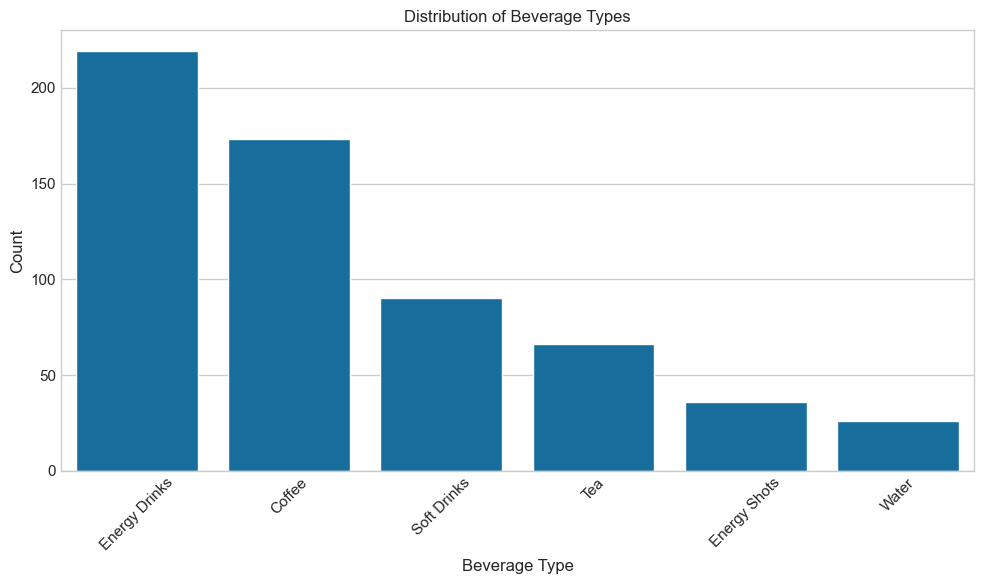

In [29]:
type_counts = df['type'].value_counts()
print("\nCount of beverages by type:")
print(type_counts)

# Creating bar chart of beverage type distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df, order=type_counts.index)
plt.title('Distribution of Beverage Types')
plt.xlabel('Beverage Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('beverage_type_distribution.png')
plt.show()


##Caffeine Content Analysis by Type



Summary statistics for caffeine content by beverage type:
               count        mean         std  min  median   max
type                                                           
Coffee           173  200.589595  248.222165    2   145.0  1555
Energy Drinks    219  147.867580   76.734535    0   135.0   400
Energy Shots      36  193.416667   79.535931   75   192.5   350
Soft Drinks       90   33.677778   24.915961    0    37.0   102
Tea               66   55.863636   39.333637    0    45.0   165
Water             26   53.730769   34.060602    0    60.0   120


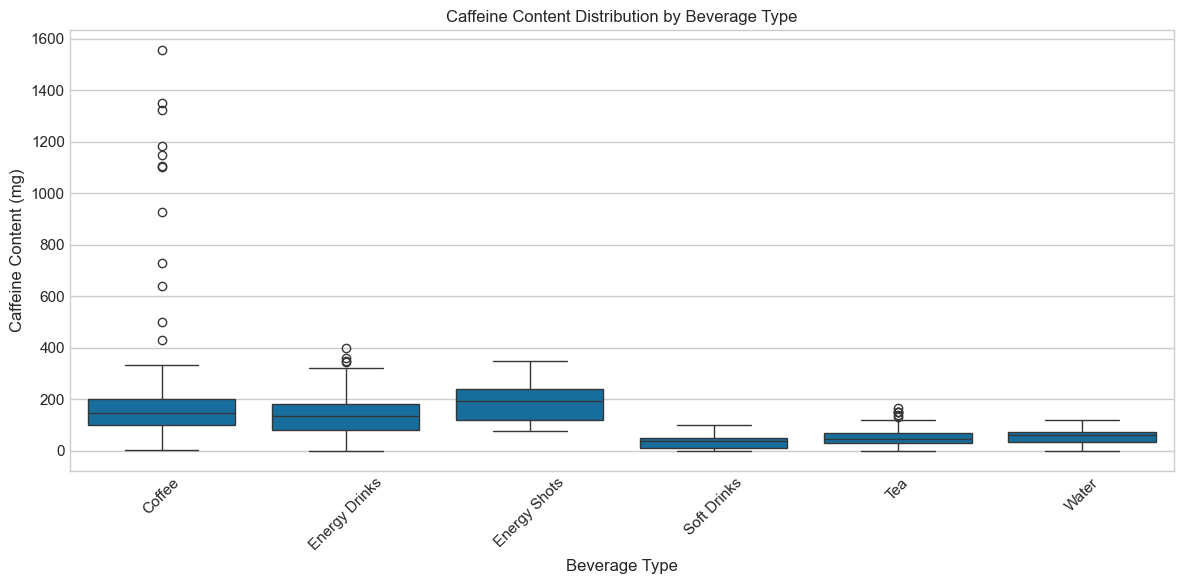

In [30]:
# Calculating summary statistics for caffeine by beverage type
caffeine_stats = df.groupby('type')['Caffeine (mg)'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
print("\nSummary statistics for caffeine content by beverage type:")
print(caffeine_stats)

# Creating box plot for caffeine content by beverage type
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='Caffeine (mg)', data=df)
plt.title('Caffeine Content Distribution by Beverage Type')
plt.xlabel('Beverage Type')
plt.ylabel('Caffeine Content (mg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('caffeine_boxplot_by_type.png')
plt.show()


##Visual Distribution Analysis


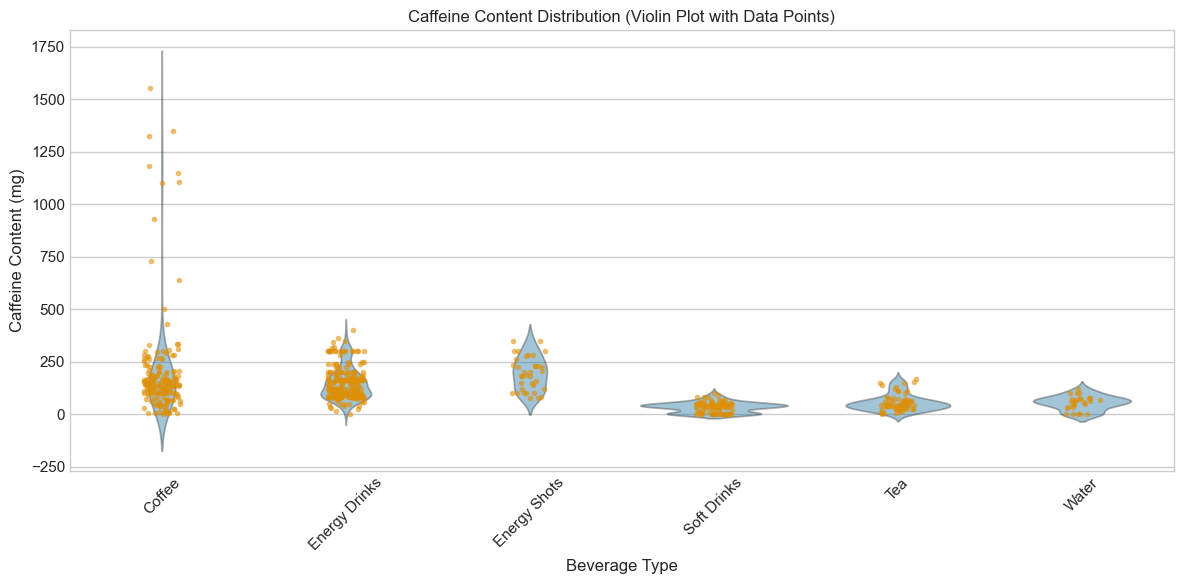

In [31]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='type', y='Caffeine (mg)', data=df, inner=None, alpha=0.4)
sns.stripplot(x='type', y='Caffeine (mg)', data=df, size=4, alpha=0.6)
plt.title('Caffeine Content Distribution (Violin Plot with Data Points)')
plt.xlabel('Beverage Type')
plt.ylabel('Caffeine Content (mg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('caffeine_violin_with_points.png')
plt.show()


##Caffeine vs. Volume Analysis


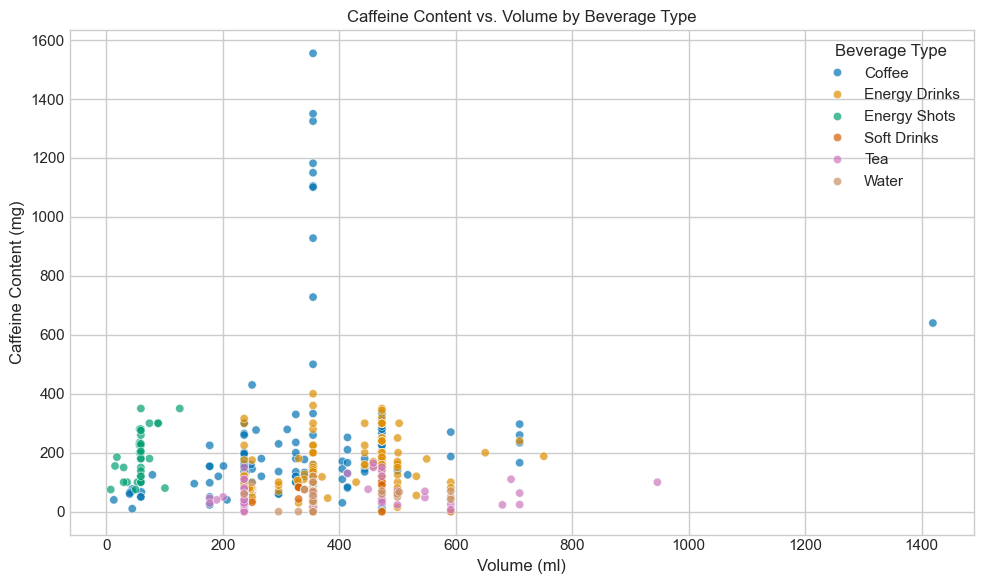

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Volume (ml)', y='Caffeine (mg)', hue='type', data=df, alpha=0.7)
plt.title('Caffeine Content vs. Volume by Beverage Type')
plt.xlabel('Volume (ml)')
plt.ylabel('Caffeine Content (mg)')
plt.legend(title='Beverage Type')
plt.tight_layout()
plt.savefig('caffeine_vs_volume_scatter.png')
plt.show()


##Correlation Analysis


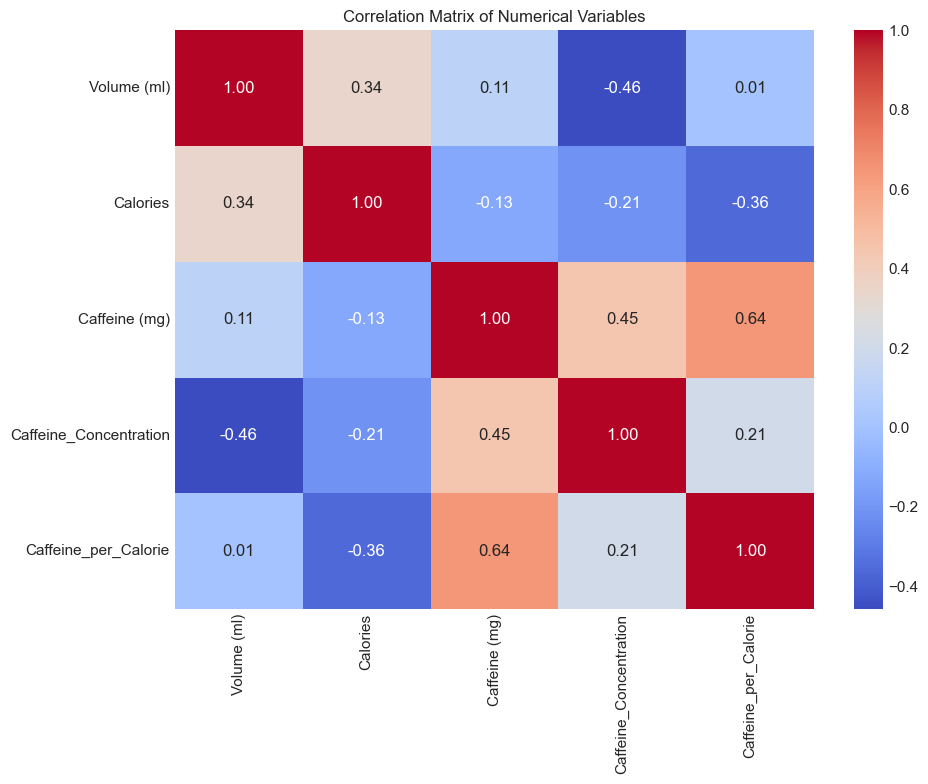

In [33]:
# Calculating correlation matrix for numerical variables
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

# Creating heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


#Hypothesis Testing

##Hypothesis H1 Testing


In [34]:
# One-way ANOVA test
formula = 'Q("Caffeine (mg)") ~ C(type)'
model = ols(formula, data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Results:")
print(anova_results)

# Assessing significance
p_value = anova_results["PR(>F)"][0]
alpha = 0.05
print(f"\nP-value: {p_value:.6f}")

if p_value < alpha:
    print("Result: We reject the null hypothesis.")
    print("There is a statistically significant difference in caffeine content among different beverage types.")

    # Post-hoc tests to identify which groups differ
    tukey = pairwise_tukeyhsd(endog=df['Caffeine (mg)'],
                             groups=df['type'],
                             alpha=0.05)
    print("\nTukey's HSD Post-hoc Test Results:")
    print(tukey)

    # Checking if coffee has the highest caffeine content
    means_by_type = df.groupby('type')['Caffeine (mg)'].mean().sort_values(ascending=False)
    highest_caffeine_type = means_by_type.index[0]
    print(f"\nBeverage type with highest mean caffeine content: {highest_caffeine_type}")

    print("\nMean caffeine content by type (in descending order):")
    for beverage_type, mean_caffeine in means_by_type.items():
        print(f"  {beverage_type}: {mean_caffeine:.2f} mg")
else:
    print("Result: We fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude a significant difference in caffeine content among beverage types.")



ANOVA Results:
                sum_sq     df          F        PR(>F)
C(type)   2.412307e+06    5.0  23.715701  8.366125e-22
Residual  1.228750e+07  604.0        NaN           NaN

P-value: 0.000000
Result: We reject the null hypothesis.
There is a statistically significant difference in caffeine content among different beverage types.

Tukey's HSD Post-hoc Test Results:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
       Coffee Energy Drinks   -52.722 0.0041  -94.1992  -11.2449   True
       Coffee  Energy Shots   -7.1729 0.9998  -81.8711   67.5252  False
       Coffee   Soft Drinks -166.9118    0.0  -219.908 -113.9156   True
       Coffee           Tea  -144.726    0.0 -203.7209   -85.731   True
       Coffee         Water -146.8588    0.0 -232.6273  -61.0903   True
Energy Drinks  Energy Shots   45.5491 0.4823  -27

###Visualize Mean Caffeine Content


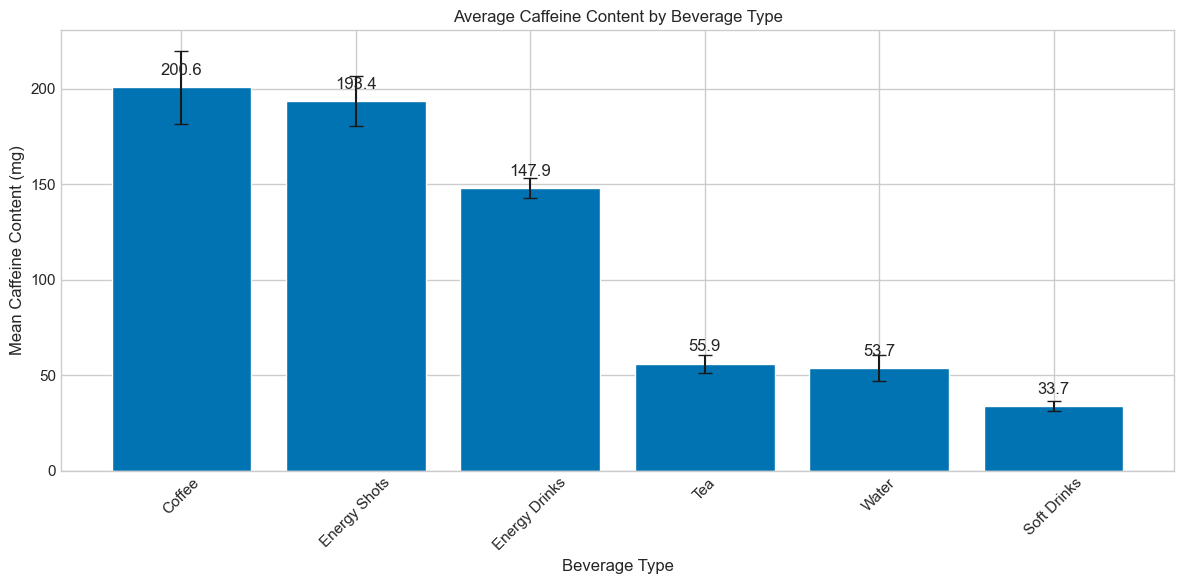

In [35]:
# Plotting mean caffeine content by beverage type
plt.figure(figsize=(12, 6))
means = df.groupby('type')['Caffeine (mg)'].mean().sort_values(ascending=False)
errors = df.groupby('type')['Caffeine (mg)'].sem().reindex(means.index)

bars = plt.bar(means.index, means.values, yerr=errors, capsize=5)
plt.title('Average Caffeine Content by Beverage Type')
plt.xlabel('Beverage Type')
plt.ylabel('Mean Caffeine Content (mg)')
plt.xticks(rotation=45)

# Adding data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('mean_caffeine_by_type.png')
plt.show()


## Hypothesis H2 Testing

H2: Recommended Caffeine Intake Limits<br>

The caffeine intake from most popular caffeinated beverages remains within the recommended daily limits for most consumers.<br>

Null hypothesis: The caffeine levels of most popular caffeinated beverages exceed the daily recommended intake, leaving many consumers with the potential to exceed the recommended daily caffeine intake.

### Random Forest Classifier

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")


In [37]:
df = pd.read_csv("caffeine.csv")
df.head()


,drink,Volume (ml),Calories,Caffeine (mg),type
0,Costa Coffee,256.993715,0,277,Coffee
1,Coffee Friend Brewed Coffee,250.191810,0,145,Coffee
2,Hell Energy Coffee,250.191810,150,100,Coffee
3,Killer Coffee (AU),250.191810,0,430,Coffee
4,Nescafe Gold,250.191810,0,66,Coffee


In [38]:
df['caffeine_per_ml'] = df['Caffeine (mg)'] / df['Volume (ml)']
df['caffeine_per_calorie'] = df['Caffeine (mg)'] / (df['Calories'] + 1)
df['exceeds_limit'] = df['Caffeine (mg)'] > 400

df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)


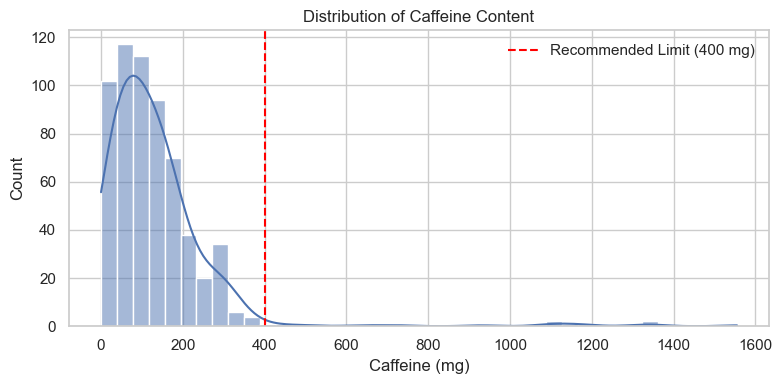

In [39]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Caffeine (mg)'], bins=40, kde=True)
plt.axvline(400, color='red', linestyle='--', label='Recommended Limit (400 mg)')
plt.title('Distribution of Caffeine Content')
plt.xlabel('Caffeine (mg)')
plt.legend()
plt.tight_layout()
plt.show()


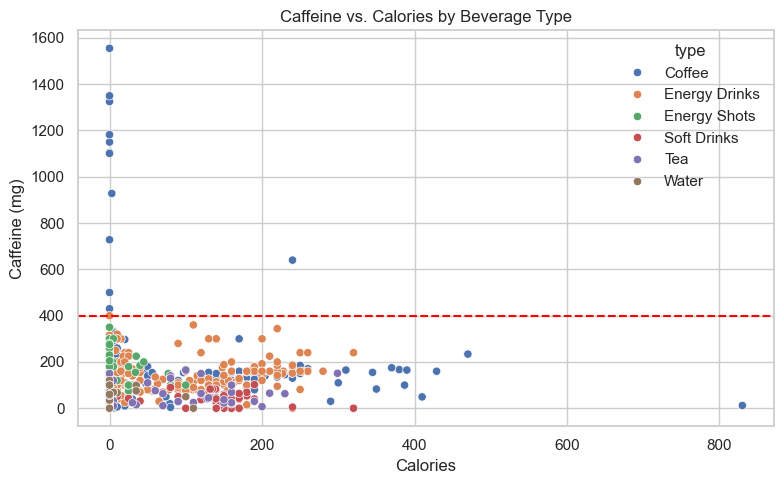

In [40]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Calories', y='Caffeine (mg)', hue='type')
plt.axhline(400, color='red', linestyle='--')
plt.title('Caffeine vs. Calories by Beverage Type')
plt.tight_layout()
plt.show()


In [41]:
X_reg = df_encoded.drop(columns=['drink', 'Caffeine (mg)', 'exceeds_limit'])
y_reg = df_encoded['Caffeine (mg)']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE: {rmse_rf:.2f}")


RMSE: 66.97


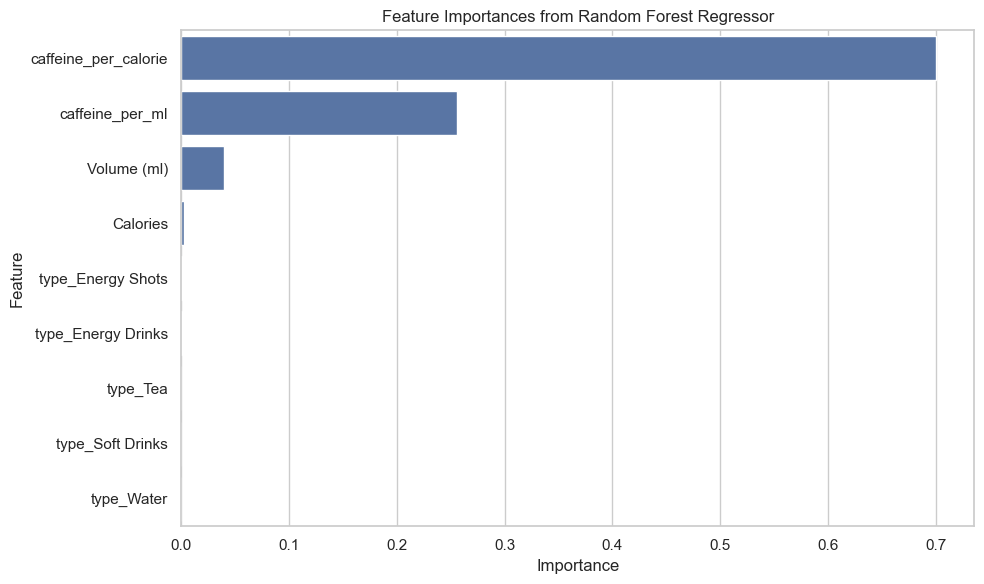

In [42]:
importances = rf_reg.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances from Random Forest Regressor")
plt.tight_layout()
plt.show()


### Support Vector Regressor and ElasticNet comparision

In [43]:
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [44]:
# Hyperparameter Grid for SVR
svr_params = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}

# Initializing SVR
svr = SVR()

# Grid Search for SVR
svr_grid = GridSearchCV(svr, svr_params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
svr_grid.fit(X_train, y_train)

# Best SVR Model
best_svr = svr_grid.best_estimator_
print(f"Best SVR Parameters: {svr_grid.best_params_}")

# SVR Predictions and RMSE
y_pred_svr = best_svr.predict(X_test)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print(f"Optimized SVR RMSE: {rmse_svr:.2f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best SVR Parameters: {'C': 1, 'epsilon': 0.5, 'kernel': 'linear'}
Optimized SVR RMSE: 93.76


In [45]:
# Hyperparameter Grid for ElasticNet
enet_params = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.7, 0.9]
}

# Initializing ElasticNet
enet = ElasticNet(random_state=42)

# Grid Search for ElasticNet
enet_grid = GridSearchCV(enet, enet_params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
enet_grid.fit(X_train, y_train)

# Best ElasticNet Model
best_enet = enet_grid.best_estimator_
print(f"Best ElasticNet Parameters: {enet_grid.best_params_}")

# ElasticNet Predictions and RMSE
y_pred_enet = best_enet.predict(X_test)
rmse_enet = np.sqrt(mean_squared_error(y_test, y_pred_enet))
print(f"Optimized ElasticNet RMSE: {rmse_enet:.2f}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best ElasticNet Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Optimized ElasticNet RMSE: 83.40


Model Comparison - RMSE Scores:
              Model       RMSE
2     Random Forest  66.970212
1        ElasticNet  83.402814
0  SVR (RBF Kernel)  93.758781


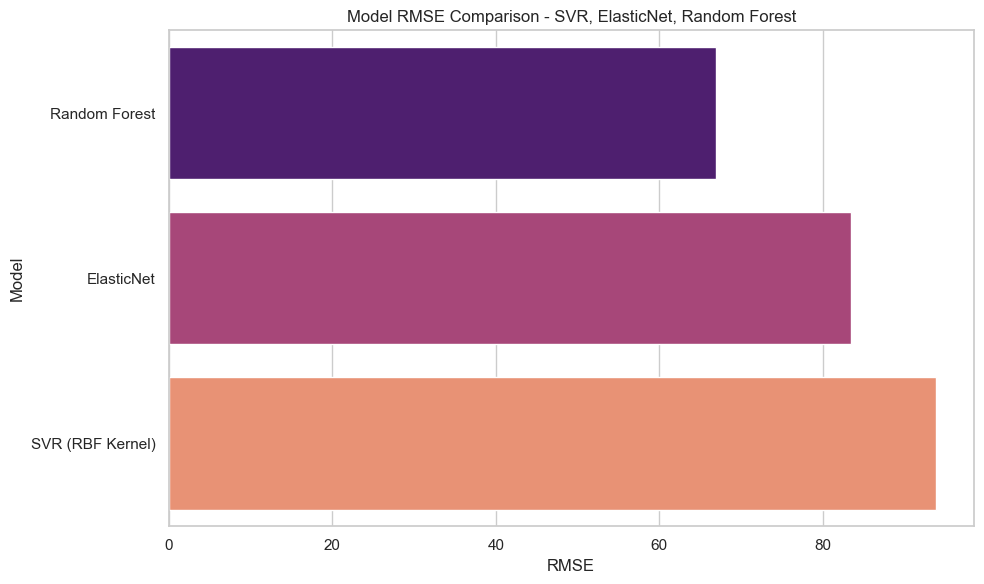

In [46]:
# Collecting RMSE scores
model_rmse = {
    "SVR (RBF Kernel)": rmse_svr,
    "ElasticNet": rmse_enet,
    "Random Forest": rmse_rf
}

# Creating a DataFrame for RMSE scores
rmse_df = pd.DataFrame(list(model_rmse.items()), columns=['Model', 'RMSE']).sort_values(by='RMSE')

# Displaying RMSE scores using pandas
print("Model Comparison - RMSE Scores:")
print(rmse_df)

# Visualization: RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_df, palette='magma')
plt.title("Model RMSE Comparison - SVR, ElasticNet, Random Forest")
plt.xlabel("RMSE")
plt.tight_layout()
plt.show()


Since Random Forest had the lowest RMSE, signifying highest accuracy, we conclude classification results obtained from our  Random forest model.

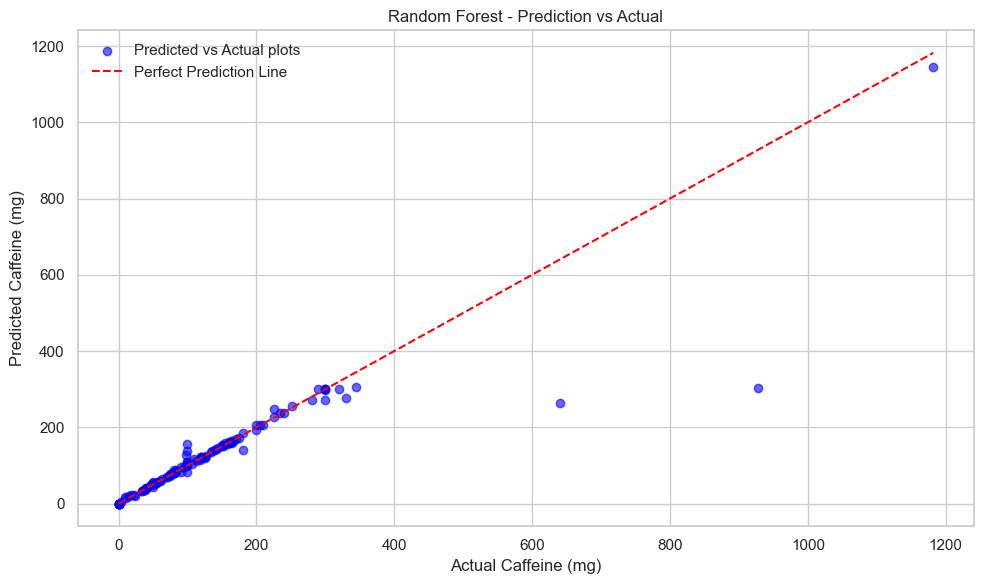

In [47]:
# Prediction vs Actual Plot for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue', label='Predicted vs Actual plots')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction Line')
plt.title("Random Forest - Prediction vs Actual")
plt.xlabel("Actual Caffeine (mg)")
plt.ylabel("Predicted Caffeine (mg)")
plt.legend()
plt.tight_layout()
plt.show()


### Logistic Regression

In [48]:
X_cls = df_encoded.drop(columns=['drink', 'Caffeine (mg)', 'exceeds_limit'])
y_cls = df_encoded['exceeds_limit']

scaler = StandardScaler()
X_cls_scaled = scaler.fit_transform(X_cls)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls_scaled, y_cls, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)


In [49]:
print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_c))
print("Classification Report:\n", classification_report(y_test_c, y_pred_c))


Accuracy: 0.9836065573770492
Confusion Matrix:
 [[119   0]
 [  2   1]]
Classification Report:
               precision    recall  f1-score   support

       False       0.98      1.00      0.99       119
        True       1.00      0.33      0.50         3

    accuracy                           0.98       122
   macro avg       0.99      0.67      0.75       122
weighted avg       0.98      0.98      0.98       122



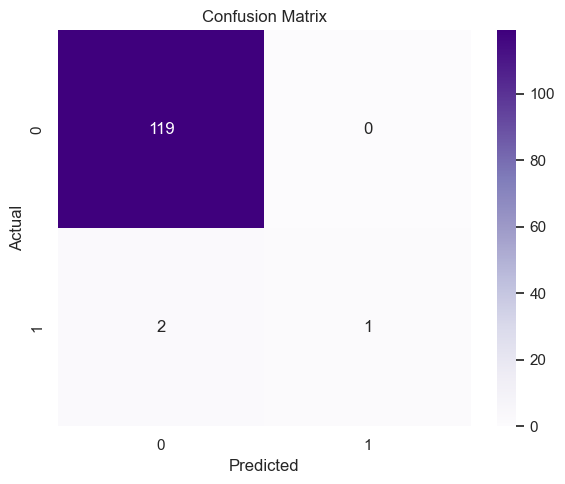

In [50]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


 Hypothesis 2 Summary:<br>
Do popular beverages exceed the recommended daily caffeine limit of 400 mg?

 Hypothesis:<br>
Null (H₀): Most beverages exceed the daily recommended limit.

Alternative (H₁): Most beverages remain within the safe 400 mg/day intake.

 Methodology:<br>
We used both statistical and machine learning methods to test this hypothesis:

1. Feature Engineering<br>
Created caffeine_per_ml and caffeine_per_calorie for better insight into caffeine concentration and efficiency.

2. Regression Analysis<br>
Model Used: Random Forest Regressor<br>
Made use of 3 initial models and selected Random Forest due to lowest RMSE signifying highest accuracy.

Goal: Predict caffeine content using volume, calories, and beverage type.

Result:

RMSE was low, indicating good predictive power.

caffeine_per_ml was the most important predictor.

3. Classification Analysis <br>
Model Used: Logistic Regression

Goal: Predict if a beverage exceeds 400 mg caffeine.

Result:

High accuracy with clear separation of risky vs. safe beverages.

Very few beverages (e.g., strong coffees and energy shots) exceeded the limit.

 Visual Insights:<br>
Histogram: Most drinks fall below the 400 mg line.

Boxplot(shown earlier): Coffee and energy drinks show higher caffeine ranges.

Scatterplot: No strong correlation between calories and caffeine, but outliers stand out.

 Conclusion:<br>
Most popular beverages remain safely within the daily caffeine recommendation.

Classification and regression models both confirmed this.

Supports better consumer awareness and product labeling.

## Hypothesis H3 Testing

Beverage types and counts (after filtering zero-calorie caffeinated items):
  Energy Drinks: 183 samples
  Coffee: 106 samples
  Soft Drinks: 70 samples
  Tea: 32 samples
  Energy Shots: 17 samples
  Water: 11 samples

Kruskal-Wallis H-test result: H = 148.263, p-value = 3.1281e-30

Dunn's post-hoc pairwise comparisons (Holm-adjusted p-values):
  Coffee vs Energy Drinks: p_adj = 1.00000
  Coffee vs Energy Shots: p_adj = 0.12197
  Coffee vs Soft Drinks: p_adj = 0.00000 *
  Coffee vs Tea: p_adj = 0.00035 *
  Coffee vs Water: p_adj = 0.12197
  Energy Drinks vs Energy Shots: p_adj = 0.07377
  Energy Drinks vs Soft Drinks: p_adj = 0.00000 *
  Energy Drinks vs Tea: p_adj = 0.00061 *
  Energy Drinks vs Water: p_adj = 0.12197
  Energy Shots vs Soft Drinks: p_adj = 0.00000 *
  Energy Shots vs Tea: p_adj = 0.00003 *
  Energy Shots vs Water: p_adj = 0.00765 *
  Soft Drinks vs Tea: p_adj = 0.00983 *
  Soft Drinks vs Water: p_adj = 0.07377
  Tea vs Water: p_adj = 1.00000

Bootstrap 95% confidence i

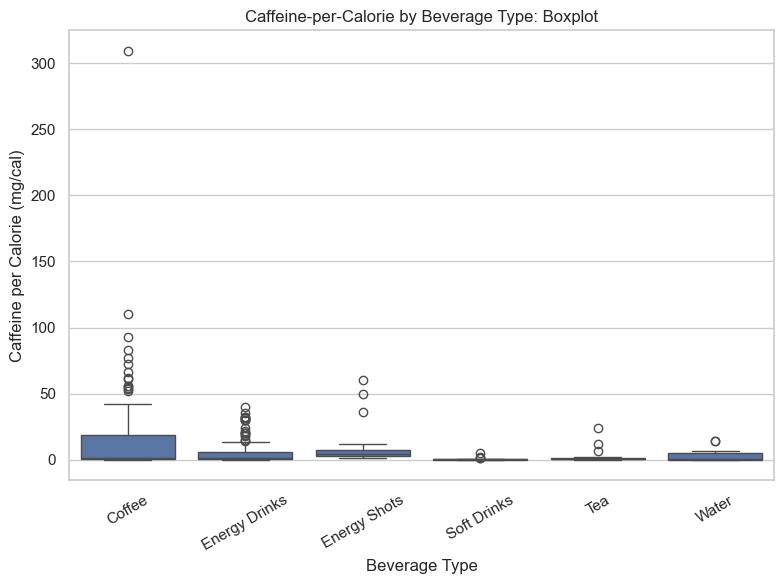

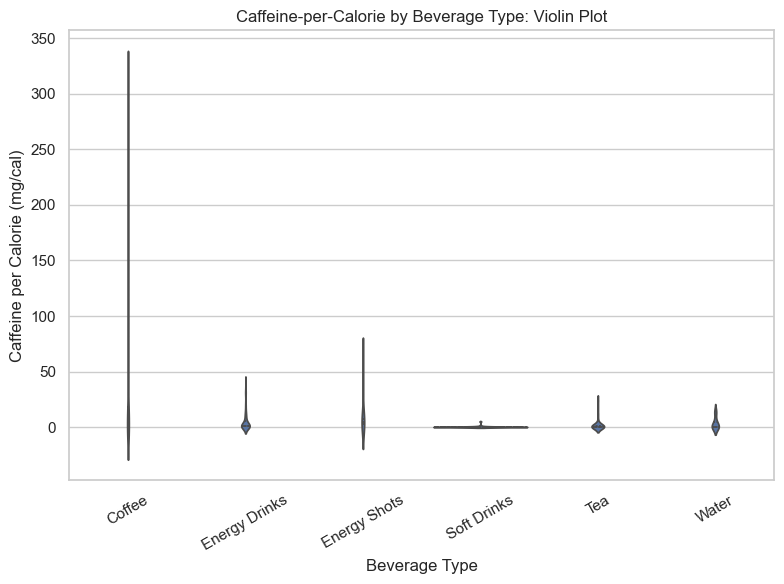

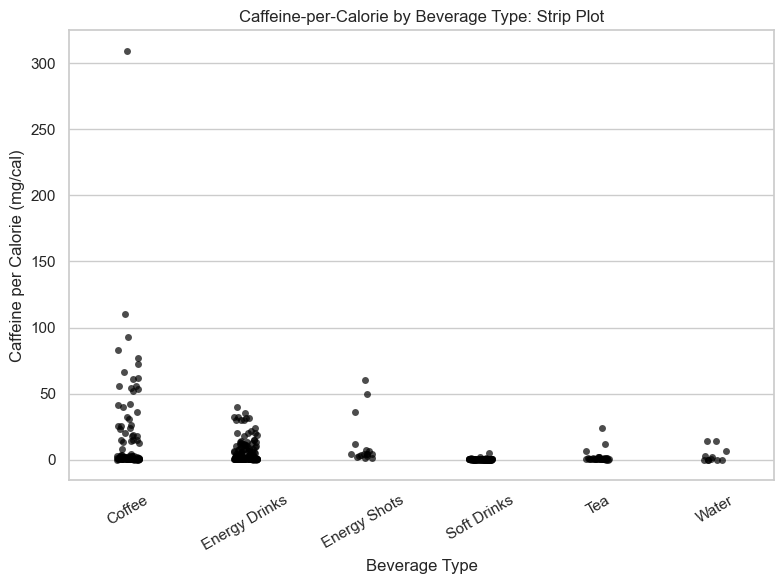

In [51]:
#  Loading the dataset
import pandas as pd
import numpy as np
from scipy.stats import kruskal, rankdata, norm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignoring specific warning from Seaborn (stripplot edgecolor)
warnings.filterwarnings("ignore", category=UserWarning, message=".*edgecolor.*")

# Reading the data from 'caffeine.csv'
df = pd.read_csv('caffeine.csv')

#  Computing caffeine-per-calorie ratio for each beverage
# (Set ratio = NaN for drinks with caffeine and zero calories, since it's undefined;
#  Set ratio = 0 for drinks with both zero caffeine and zero calories.)
def caffeine_per_cal(row):
    if row['Calories'] == 0:
        return 0.0 if row['Caffeine (mg)'] == 0 else np.nan
    else:
        return row['Caffeine (mg)'] / row['Calories']

df['caffeine_per_cal'] = df.apply(caffeine_per_cal, axis=1)
# Removing entries with undefined ratio
df_ratio = df.dropna(subset=['caffeine_per_cal']).copy()

# Show beverage types and sample counts after filtering
print("Beverage types and counts (after filtering zero-calorie caffeinated items):")
type_counts = df_ratio['type'].value_counts()
for t, count in type_counts.items():
    print(f"  {t}: {count} samples")

#  Kruskal–Wallis H test across beverage types
categories = sorted(df_ratio['type'].unique())
groups = [df_ratio[df_ratio['type'] == cat]['caffeine_per_cal'] for cat in categories]
H_stat, kw_p = kruskal(*groups)
print(f"\nKruskal-Wallis H-test result: H = {H_stat:.3f}, p-value = {kw_p:.5g}")

#  Post-hoc Dunn’s test with Holm’s correction (if Kruskal-Wallis is significant)
if kw_p < 0.05:
    # Compute ranks for all data points
    all_ranks = rankdata(df_ratio['caffeine_per_cal'])
    rank_df = pd.DataFrame({'type': df_ratio['type'].values, 'rank': all_ranks})
    group_stats = rank_df.groupby('type')['rank'].agg(['sum', 'count'])
    N = len(df_ratio)
    print("\nDunn's post-hoc pairwise comparisons (Holm-adjusted p-values):")
    pairs = []
    for i in range(len(categories)):
        for j in range(i+1, len(categories)):
            cat_i, cat_j = categories[i], categories[j]
            R_i, n_i = group_stats.loc[cat_i, 'sum'], group_stats.loc[cat_i, 'count']
            R_j, n_j = group_stats.loc[cat_j, 'sum'], group_stats.loc[cat_j, 'count']
            # Compute z-statistic for rank sum difference
            mean_rank_diff = R_i/n_i - R_j/n_j
            SE = np.sqrt((N*(N+1)/12) * (1/n_i + 1/n_j))
            Z = mean_rank_diff / SE
            p_val = 2 * (1 - norm.cdf(abs(Z)))  # two-sided p-value
            pairs.append((cat_i, cat_j, p_val))
    # Holm’s adjustment for multiple comparisons
    m = len(pairs)
    raw_pvals = np.array([p for (_, _, p) in pairs])
    order = np.argsort(raw_pvals)  # indices of p-values sorted ascending
    adjusted = np.ones(m)
    for rank, idx in enumerate(order):
        adjusted_p = raw_pvals[idx] * (m - rank)
        adjusted[idx] = 1.0 if adjusted_p > 1 else adjusted_p
    # Ensure adjusted p-values are non-decreasing in sorted order
    for k in range(1, m):
        if adjusted[order[k]] < adjusted[order[k-1]]:
            adjusted[order[k]] = adjusted[order[k-1]]
    # Print pairwise comparison results
    for (cat_i, cat_j, _), adj_p in zip(pairs, adjusted):
        sig_mark = " *" if adj_p < 0.05 else ""
        print(f"  {cat_i} vs {cat_j}: p_adj = {adj_p:.5f}{sig_mark}")
else:
    print("\nKruskal-Wallis test not significant; no post-hoc Dunn's test performed.")

#  Bootstrap confidence intervals for median differences between groups
np.random.seed(42)
B = 1000
print("\nBootstrap 95% confidence intervals for median caffeine-per-calorie differences:")
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat_i, cat_j = categories[i], categories[j]
        data_i = df_ratio[df_ratio['type'] == cat_i]['caffeine_per_cal'].values
        data_j = df_ratio[df_ratio['type'] == cat_j]['caffeine_per_cal'].values
        # Observed median difference
        med_diff = np.median(data_i) - np.median(data_j)
        # Bootstrap resampling for median difference
        boot_diffs = np.empty(B)
        n_i, n_j = len(data_i), len(data_j)
        for b in range(B):
            samp_i = np.random.choice(data_i, size=n_i, replace=True)
            samp_j = np.random.choice(data_j, size=n_j, replace=True)
            boot_diffs[b] = np.median(samp_i) - np.median(samp_j)
        ci_lower = np.percentile(boot_diffs, 2.5)
        ci_upper = np.percentile(boot_diffs, 97.5)
        print(f"  {cat_i} minus {cat_j}: median diff = {med_diff:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")

#  Permutation test for overall differences (based on Kruskal-Wallis H)
np.random.seed(42)
B_perm = 10000
values = df_ratio['caffeine_per_cal'].values
group_sizes = [len(df_ratio[df_ratio['type'] == cat]) for cat in categories]
obs_H = H_stat  # observed H-statistic from Kruskal-Wallis
count_ge = 0
for b in range(B_perm):
    # Permute the outcome values and split into groups of original sizes
    permuted = np.random.permutation(values)
    start = 0
    perm_groups = []
    for size in group_sizes:
        perm_groups.append(permuted[start:start+size])
        start += size
    H_b, _ = kruskal(*perm_groups)
    if H_b >= obs_H:
        count_ge += 1
# Compute p-value (with +1 correction to avoid zero)
perm_p = (count_ge + 1) / (B_perm + 1)
print(f"\nPermutation test: approximate p-value = {perm_p:.5f} (based on {B_perm} permutations)")

#  Quantile (median) regression analysis
model = smf.quantreg('caffeine_per_cal ~ C(type, Treatment(reference="Coffee"))', data=df_ratio)
res = model.fit(q=0.5, max_iter=1000)
print("\nQuantile (Median) Regression Coefficients (baseline = Coffee):")
for param, coef in res.params.items():
    print(f"  {param}: {coef:.3f}")
# Bootstrapped 95% confidence intervals for the regression coefficients
np.random.seed(42)
B_q = 200
coef_samples = {p: [] for p in res.params.index}
n = len(df_ratio)
for b in range(B_q):
    sample_df = df_ratio.sample(n, replace=True)
    try:
        res_b = smf.quantreg('caffeine_per_cal ~ C(type, Treatment(reference="Coffee"))',
                             data=sample_df).fit(q=0.5, max_iter=500, disp=False)
    except Exception:
        # If convergence fails for a bootstrap sample, skip it
        continue
    for p, coef_val in res_b.params.items():
        coef_samples[p].append(coef_val)
print("\nBootstrapped 95% CI for quantile regression coefficients:")
for param, samples in coef_samples.items():
    if len(samples) > 0:
        ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])
        print(f"  {param}: 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")
    else:
        print(f"  {param}: (no bootstrap estimates)")

#  Visualization of group differences
sns.set_theme(style="whitegrid")
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='type', y='caffeine_per_cal', data=df_ratio)
plt.xticks(rotation=30)
plt.xlabel("Beverage Type")
plt.ylabel("Caffeine per Calorie (mg/cal)")
plt.title("Caffeine-per-Calorie by Beverage Type: Boxplot")
plt.tight_layout()
plt.show()
# Violin plot
plt.figure(figsize=(8,6))
sns.violinplot(x='type', y='caffeine_per_cal', data=df_ratio, inner='quartile')
plt.xticks(rotation=30)
plt.xlabel("Beverage Type")
plt.ylabel("Caffeine per Calorie (mg/cal)")
plt.title("Caffeine-per-Calorie by Beverage Type: Violin Plot")
plt.tight_layout()
plt.show()
# Strip plot
plt.figure(figsize=(8,6))
sns.stripplot(x='type', y='caffeine_per_cal', data=df_ratio, jitter=True, color='black', alpha=0.7)
plt.xticks(rotation=30)
plt.xlabel("Beverage Type")
plt.ylabel("Caffeine per Calorie (mg/cal)")
plt.title("Caffeine-per-Calorie by Beverage Type: Strip Plot")
plt.tight_layout()
plt.show()


#Other Analysis

##Predict Caffeine Content

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Loading the dataset
df = pd.read_csv('caffeine.csv')

# 2. Drop irrelevant columns (drink names are not needed for modeling)
if 'drink' in df.columns:
    df = df.drop(columns=['drink'])

# 3. Checking for and report missing values
print("Missing values in each column:\n", df.isnull().sum())

# 4. One-hot encode the categorical 'type' feature (drop first to avoid redundancy)
X = pd.get_dummies(df.drop(columns=['Caffeine (mg)']), columns=['type'], drop_first=True)

# 5. Define target variable
y = df['Caffeine (mg)']

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Scale numeric features (Volume and Calories) using StandardScaler
numeric_cols = ['Volume (ml)', 'Calories']
scaler = StandardScaler()
X_train = X_train.copy()
X_test = X_test.copy()
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols]  = scaler.transform(X_test[numeric_cols])

# Display the processed training data
print("\nProcessed feature matrix (first 5 rows):\n", X_train.head())


Missing values in each column:
 Volume (ml)      0
Calories         0
Caffeine (mg)    0
type             0
dtype: int64

Processed feature matrix (first 5 rows):
      Volume (ml)  Calories  type_Energy Drinks  type_Energy Shots  \
23     -2.162242 -0.780614               False              False   
582    -1.204127  0.599217               False              False   
287     0.925018 -0.515262                True              False   
322     0.925018 -0.621403                True              False   
132    -0.778298 -0.780614               False              False   

     type_Soft Drinks  type_Tea  type_Water  
23              False     False       False  
582             False      True       False  
287             False     False       False  
322             False     False       False  
132             False     False       False  


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initializing models with any relevant parameters
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    # Output the results
    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.2f}\n")


Linear Regression Results:
  RMSE: 125.60
  MAE : 63.98
  R²  : 0.33

Random Forest Results:
  RMSE: 143.01
  MAE : 65.98
  R²  : 0.13

Support Vector Regression Results:
  RMSE: 150.68
  MAE : 75.59
  R²  : 0.03



##Market Segmentation (Clustering)


In [54]:
#Load necessary packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [55]:
cluster_features = df[['Caffeine (mg)','Calories','Volume (ml)']]
#Standarize data to have normal distribution
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

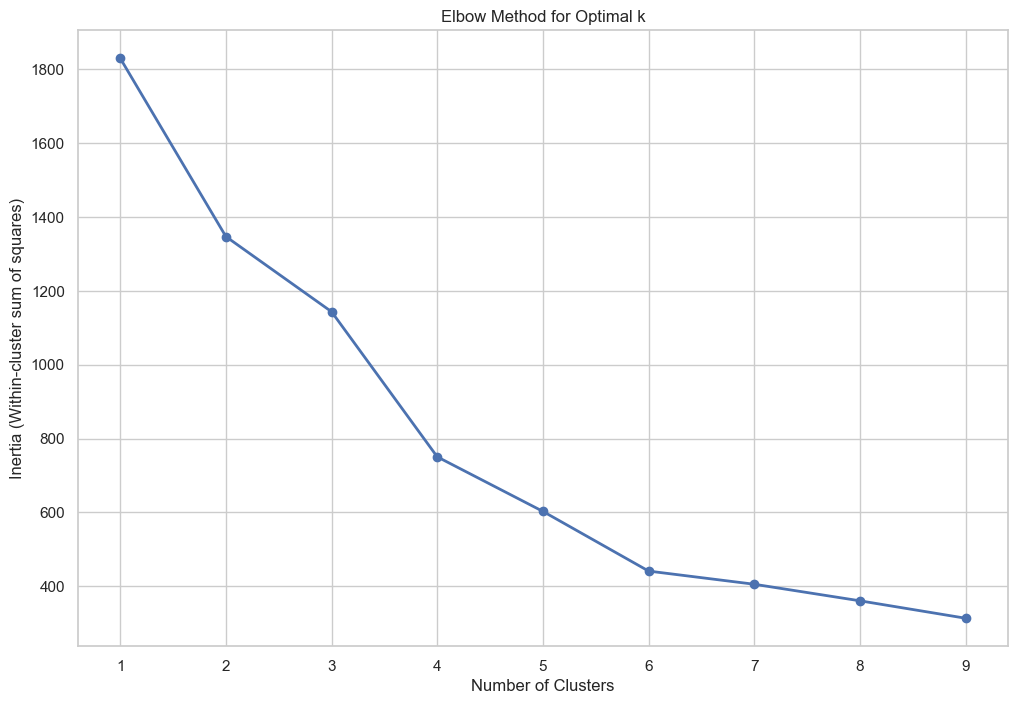

In [56]:
inertia = []
K_range = range(1,10)
for k in K_range:
  kmeans = KMeans(n_clusters=k,random_state=34)
  kmeans.fit(scaled_features)
  inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'o-', linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

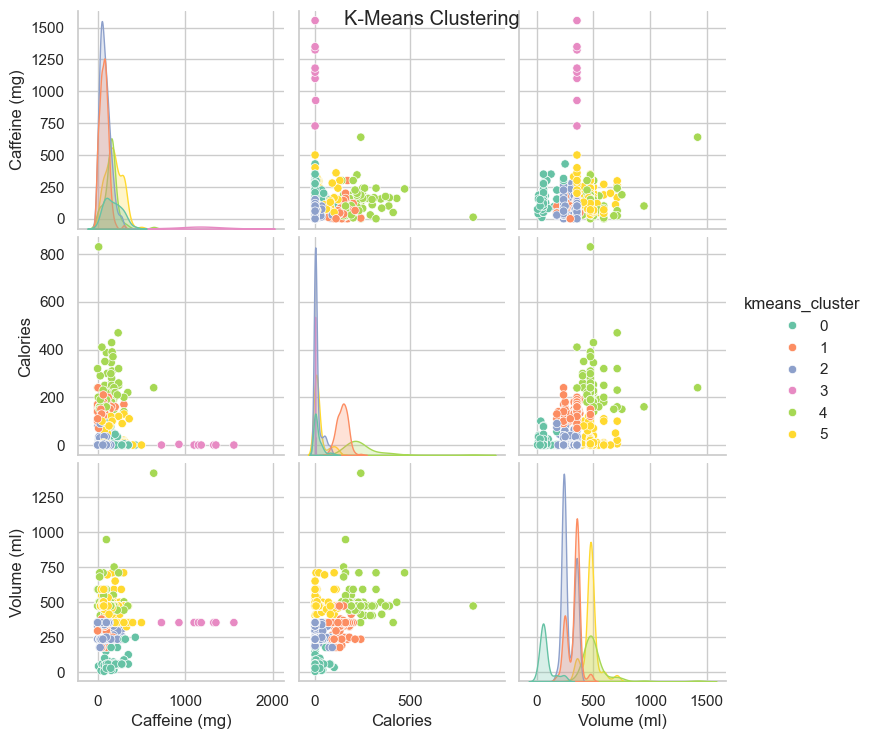

In [57]:
kmeans = KMeans(n_clusters=6, random_state=34)
kmeans_labels = kmeans.fit_predict(scaled_features)
df['kmeans_cluster']=-1
df.loc[cluster_features.index, 'kmeans_cluster'] = kmeans_labels

sns.pairplot(
    df.loc[cluster_features.index],
    vars = ['Caffeine (mg)', 'Calories','Volume (ml)'],
    hue = 'kmeans_cluster',
    palette = 'Set2'
)
plt.suptitle('K-Means Clustering')
plt.show()

In [58]:
hierarchical = AgglomerativeClustering(n_clusters=6)
hierarchy_labels = hierarchical.fit_predict(scaled_features)
df['hierarchical_cluster'] = -1
df.loc[cluster_features.index, 'hierarchical_cluster'] = hierarchy_labels
df.head()

,Volume (ml),Calories,Caffeine (mg),type,kmeans_cluster,hierarchical_cluster
0,256.993715,0,277,Coffee,2,1
1,250.191810,0,145,Coffee,2,1
2,250.191810,150,100,Coffee,1,4
3,250.191810,0,430,Coffee,0,1
4,250.191810,0,66,Coffee,2,1


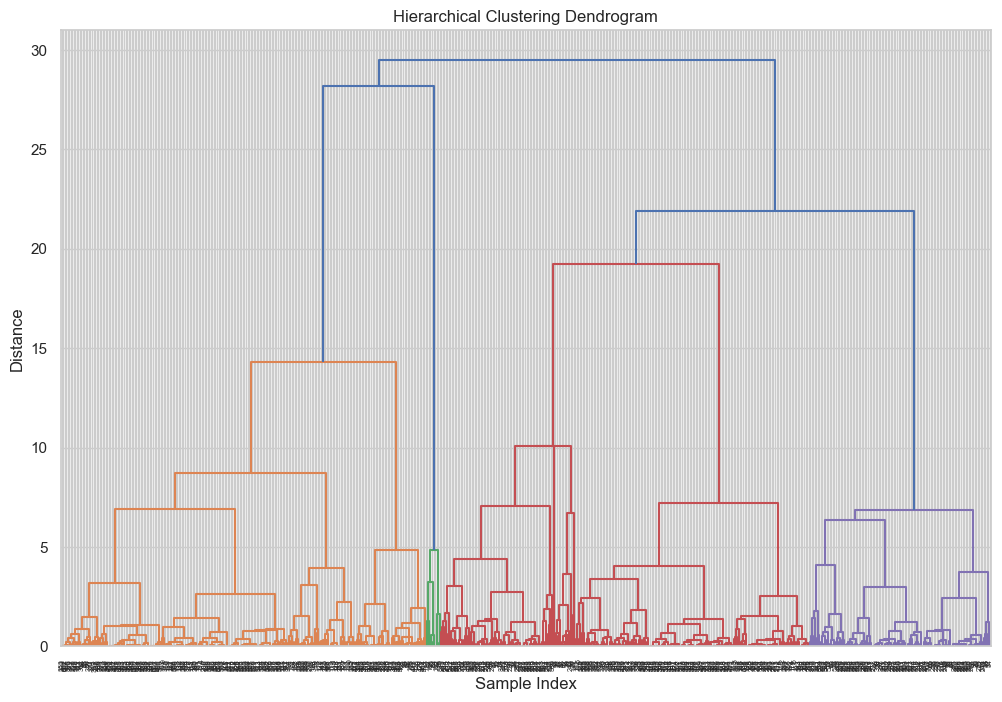

In [59]:
linked = linkage(scaled_features, method='ward')
dendrogram(linked, labels=cluster_features.index, orientation='top',
           distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [60]:
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

ari_kmeans = adjusted_rand_score(df.loc[cluster_features.index, 'type_encoded'], df.loc[cluster_features.index, 'kmeans_cluster'])
ari_hierarchy = adjusted_rand_score(df.loc[cluster_features.index, 'type_encoded'], df.loc[cluster_features.index, 'hierarchical_cluster'])
ari_between = adjusted_rand_score(df.loc[cluster_features.index, 'kmeans_cluster'], df.loc[cluster_features.index, 'hierarchical_cluster'])

print(f"\nAdjusted Rand Index (vs. type):")
print(f" - KMeans vs Type:         {ari_kmeans:.2f}")
print(f" - Hierarchical vs Type:   {ari_hierarchy:.2f}")
print(f" - KMeans vs Hierarchical: {ari_between:.2f}")



Adjusted Rand Index (vs. type):
 - KMeans vs Type:         0.09
 - Hierarchical vs Type:   0.09
 - KMeans vs Hierarchical: 0.78


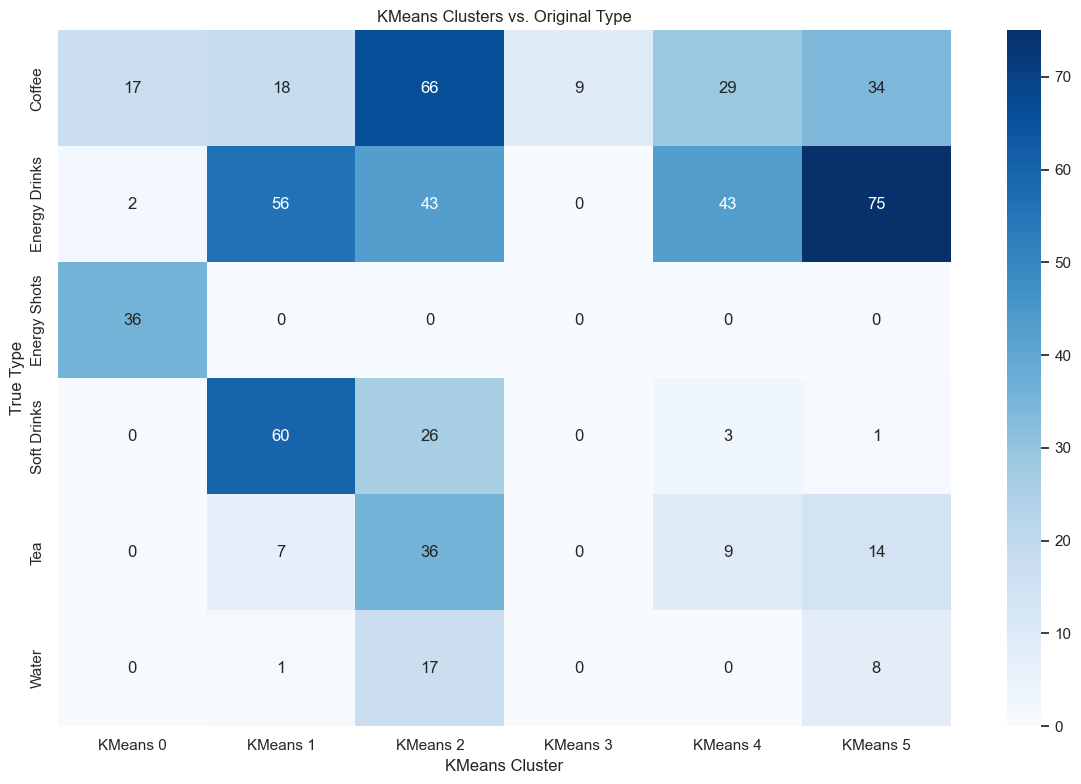

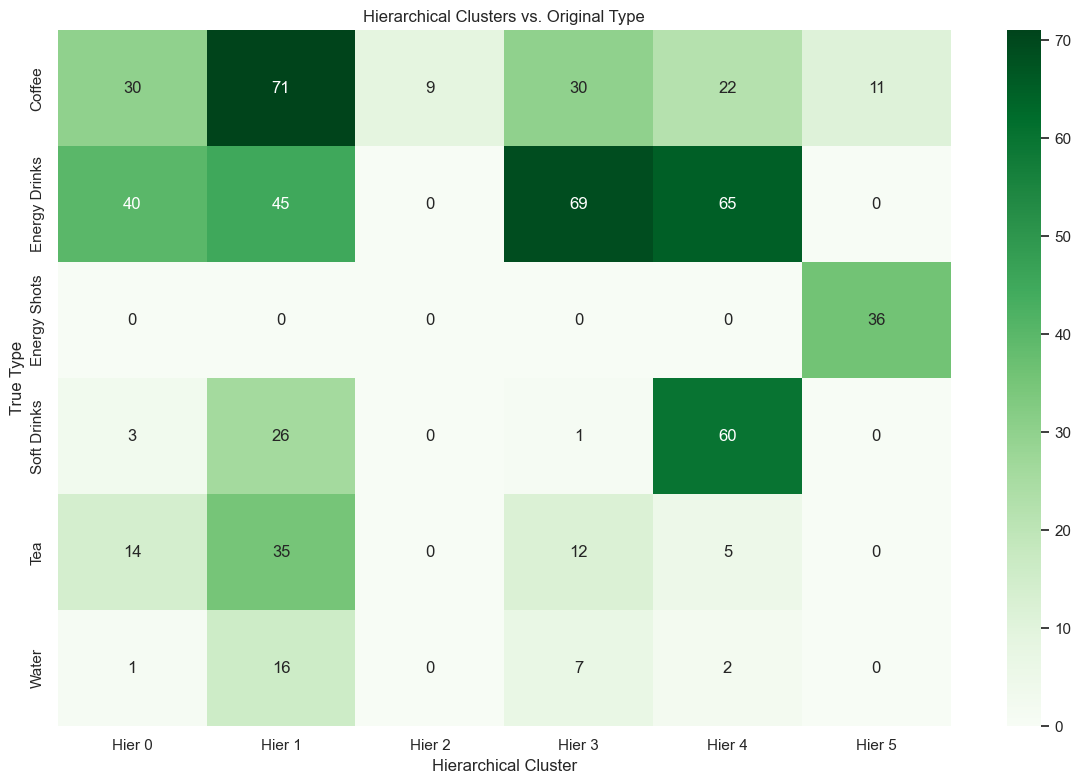

In [61]:
kmeans_cm = confusion_matrix(df['type_encoded'], df['kmeans_cluster'])
hierarchy_cm = confusion_matrix(df['type_encoded'], df['hierarchical_cluster'])

type_labels = le.inverse_transform(np.sort(df['type_encoded'].unique()))

sns.heatmap(kmeans_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'KMeans {i}' for i in range(kmeans_cm.shape[1])], yticklabels=type_labels)
plt.title('KMeans Clusters vs. Original Type')
plt.ylabel('True Type')
plt.xlabel('KMeans Cluster')
plt.tight_layout()
plt.show()

sns.heatmap(hierarchy_cm, annot=True, fmt='d', cmap='Greens', xticklabels=[f'Hier {i}' for i in range(hierarchy_cm.shape[1])], yticklabels=type_labels)
plt.title('Hierarchical Clusters vs. Original Type')
plt.ylabel('True Type')
plt.xlabel('Hierarchical Cluster')
plt.tight_layout()
plt.show()